# Visualize Training Metrics for ViT CIFAR-10

**Outputs**  
- Learning curve: train vs val loss  
- Validation accuracy per epoch  
- Learning rate per epoch  
- Confusion matrix computed from the best checkpoint  
- Optional classification report  


## 📦 Setup and Configuration

First, let's import all necessary libraries and set up the configuration for our visualization analysis.

In [1]:
import os, sys
sys.path.append(os.path.abspath("../src"))

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

import torch
from models.vit import ViT
from datasets.cifar10 import get_cifar10

EXP_DIR = "../experiments"
CHECKPOINT_PREFERENCE = "best.pt"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

exp = Path(EXP_DIR)
assert exp.exists(), f"Experiment directory not found: {EXP_DIR}"

print('Using EXP_DIR =', EXP_DIR)
print("Device:", DEVICE)

Using EXP_DIR = ../experiments
Device: cuda


## 📊 Loading Training Metrics

Let's load the training metrics from the CSV log file to analyze the model's performance during training.

In [2]:
metrics_path = os.path.join(exp, "logs/metrics.csv")
df = pd.read_csv(metrics_path)

df.head()

,epoch,train_loss,val_loss,val_acc,lr,time
0,1,1.858507,1.621516,40.65,0.000100,2025-09-13T07:54:20
1,2,1.577593,1.425135,47.90,0.000100,2025-09-13T07:54:47
2,3,1.412162,1.335633,51.21,0.000100,2025-09-13T07:55:15
3,4,1.299911,1.271668,53.62,0.000100,2025-09-13T07:55:42
4,5,1.222963,1.185377,57.66,0.000099,2025-09-13T07:56:10


## 📈 Training Performance Visualization

### Loss Curves
The learning curve shows how both training and validation losses evolve during training. This helps us understand:
- **Convergence**: Whether the model is learning effectively
- **Overfitting**: If validation loss starts increasing while training loss decreases
- **Training stability**: Smooth vs. noisy loss curves

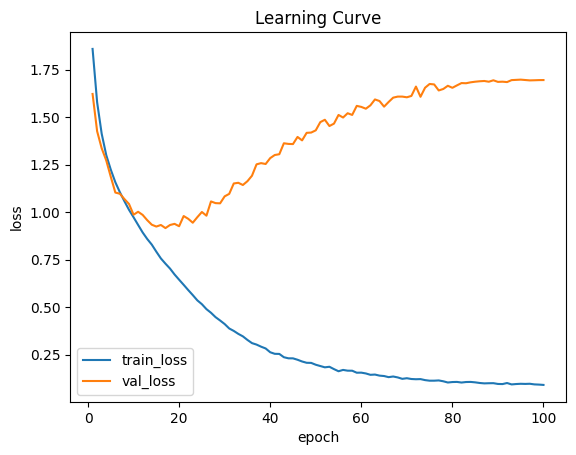

In [3]:
plt.figure()
plt.plot(df['epoch'], df['train_loss'], label='train_loss')
plt.plot(df['epoch'], df['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

### Validation Accuracy
Validation accuracy shows the model's performance on unseen data throughout training. This metric helps us:
- **Track improvement**: See how accuracy increases over epochs
- **Identify best epoch**: Find when the model achieved peak performance
- **Detect plateau**: Understand when training should be stopped

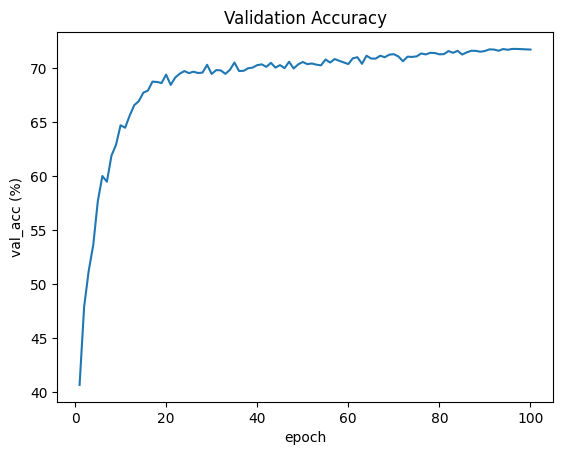

In [4]:
plt.figure()
plt.plot(df['epoch'], df['val_acc'])
plt.xlabel('epoch')
plt.ylabel('val_acc (%)')
plt.title('Validation Accuracy')
plt.show()

### Learning Rate Schedule
The learning rate schedule shows how the optimizer's learning rate changes during training. We use cosine annealing which:
- **Starts high**: For fast initial learning
- **Gradually decreases**: For fine-tuning in later epochs
- **Smooth decay**: Helps with final convergence

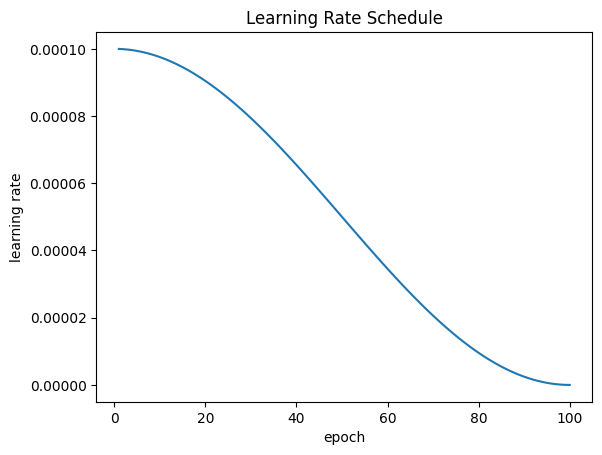

In [5]:
plt.figure()
plt.plot(df['epoch'], df['lr'])
plt.xlabel('epoch')
plt.ylabel('learning rate')
plt.title('Learning Rate Schedule')
plt.show()

## 🎯 Model Evaluation and Analysis

Now let's load the best trained model and evaluate it on the test set to get detailed performance metrics.

### Loading Best Checkpoint
We'll load the checkpoint with the highest validation accuracy for our analysis.

In [6]:
ckpt_path = os.path.join(exp, "checkpoints/best.pt")
ckpt = torch.load(ckpt_path, map_location=DEVICE)
config = ckpt.get('config', {})
print("Loaded checkpoint:", ckpt_path, "| epoch:", ckpt.get('epoch', '?'), "| val_acc:", ckpt.get('val_acc', 'NA'))

Loaded checkpoint: ../experiments/checkpoints/best.pt | epoch: 96 | val_acc: 71.77


### Initializing Model
Create the Vision Transformer model with the same configuration used during training and load the trained weights.

In [7]:
model_cfg = config.get('model', {})
model = ViT(**model_cfg).to(DEVICE)
model.load_state_dict(ckpt['model_state_dict'])
model.eval()

ViT(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (attn): MultiHeadSelfAttention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path1): DropPath()
        (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (mlp): FeedForward(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=768, out_features=192, bias=True)
          (drop): Dropout(p=0.1, inplace=False)
        )
        (drop_path2): DropPath()
      )
    )
    (nor

### Loading Test Data
Load the CIFAR-10 test dataset with the same preprocessing used during training.

In [8]:
batch_size = config.get('batch_size', 128)
_, testloader = get_cifar10(batch_size=batch_size, root="../data")

100%|██████████| 170M/170M [00:16<00:00, 10.3MB/s] 



### Collecting Predictions
Run the model on the entire test set to collect predictions for detailed analysis.

In [9]:
@torch.no_grad()
def collect_preds(loader):
    all_y, all_pred = [], []
    for x, y in loader:
        x = x.to(DEVICE)
        out = model(x)
        pred = out.argmax(1).cpu()
        all_pred.append(pred)
        all_y.append(y)

    return torch.cat(all_y).numpy(), torch.cat(all_pred).numpy()

y_true, y_pred = collect_preds(testloader)
print("Collected predictions:", y_true.shape)

Collected predictions: (10000,)


## 🔍 Detailed Performance Analysis

### Classification Report & Confusion Matrix
The confusion matrix shows how well the model distinguishes between different classes. The classification report provides detailed metrics including:
- **Precision**: How many predicted positives are actually positive
- **Recall**: How many actual positives are correctly predicted  
- **F1-score**: Harmonic mean of precision and recall
- **Support**: Number of samples for each class

Classification report:
              precision    recall  f1-score   support

           0     0.7397    0.7330    0.7363      1000
           1     0.8066    0.8090    0.8078      1000
           2     0.6983    0.6180    0.6557      1000
           3     0.5198    0.5390    0.5292      1000
           4     0.6881    0.6530    0.6701      1000
           5     0.6158    0.6330    0.6243      1000
           6     0.7812    0.8070    0.7939      1000
           7     0.7432    0.7640    0.7535      1000
           8     0.8192    0.8380    0.8285      1000
           9     0.7654    0.7830    0.7741      1000

    accuracy                         0.7177     10000
   macro avg     0.7177    0.7177    0.7173     10000
weighted avg     0.7177    0.7177    0.7173     10000



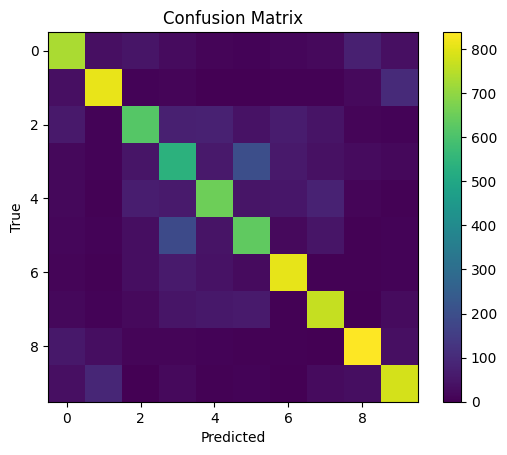

In [10]:
cm = confusion_matrix(y_true, y_pred)
print("Classification report:")
print(classification_report(y_true, y_pred, digits=4))

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.show()

### Per-Class Accuracy Analysis
This chart shows how well the model performs on each individual class. It helps identify:
- **Strongest classes**: Which objects the model recognizes best
- **Weakest classes**: Which classes need more attention or data
- **Class imbalance effects**: Whether some classes are harder to learn

**CIFAR-10 Classes:**
- 0: airplane ✈️
- 1: automobile 🚗  
- 2: bird 🐦
- 3: cat 🐱
- 4: deer 🦌
- 5: dog 🐶
- 6: frog 🐸
- 7: horse 🐴
- 8: ship 🚢
- 9: truck 🚛

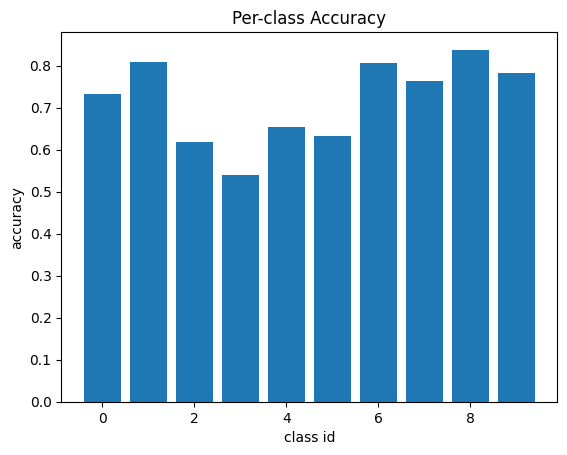

In [11]:
num_classes = cm.shape[0]
per_class_acc = cm.diagonal() / cm.sum(axis=1).clip(min=1)
plt.figure()
plt.bar(range(num_classes), per_class_acc)
plt.xlabel('class id')
plt.ylabel('accuracy')
plt.title('Per-class Accuracy')
plt.show()

---